Hybrid Botnet Detection using GA and LightGBM - Single Modal

1. **Import Required Packages**  
   
2. **Load and Prepare Datasets**  
   - Load pre-split training and testing datasets from CSV files.  
   - Inspect the data (check shapes, head, data types, etc.) to verify loading.

3. **Preprocess Data**  
   - **Remove Duplicates:** Eliminate redundant rows from both training and testing data.  
   - **Handle Missing Values:**  
     - Numeric columns: Fill with the column mean.  
     - Non-numeric columns: Fill with the most frequent value (mode).  
   - **Handle Infinite Values:** Replace any infinite values with NaN and then fill these using the column mean.  
   - **Drop Single-value Columns:** Remove columns with only a single unique value.  
   - **Clean Column Names:** Remove spaces to avoid issues in downstream processing.

4. **Feature Engineering and Selection**  
   - **Feature Selection:** Drop irrelevant columns so that the target variable (e.g., “attack”) is kept separate.  
   - **Apply SMOTE:** Balance the class distribution in the training set using SMOTE.  
   - **Scale Features:** Normalize the data using MinMaxScaler from scikit‑learn.  
   - **Genetic Algorithm for Feature Selection:**  
     - Use DEAP to set up a population of binary individuals (each represents a subset of features).  
     - Evaluate candidates on a small subsample with a fast LightGBM model to approximate performance.  
     - Run the GA for several generations, extract the best individual, and map the selected indices to actual feature names.

5. **Train LightGBM Model**  
   - **Cross-Validation and Performance Evaluation:**  
     - Use 5‑fold Stratified Cross‑Validation on the training set with only the GA‑selected features.    
     - Train the final LightGBM model using the selected features on the entire training set.  
     - Evaluate the final model on the test set and print the performance metrics (all printed in full precision without rounding).

6. **Evaluate Overfitting and Test on Unseen Data**  
   - Compare the performance metrics between training and test sets to assess if the model is overfitting.  

7. **Save Results and Final Model**  
   - Persist the final trained LightGBM model to disk using Joblib for future use or deployment.


**Importing the needed packages**

In [35]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from deap import base, creator, tools, algorithms
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import multiprocessing
from sklearn.model_selection import KFold, StratifiedKFold, learning_curve
import time
import logging
import joblib




In [36]:
# Cell 1: Data Loading and Preprocessing
# --------------------------------------
# This cell loads the IoT Bot dataset, which is already split into training 
# and testing data. We load each CSV file from the specified paths, then print
# key information such as the shape, the first few rows, and the data types 
# to verify that the data has been loaded correctly.

import pandas as pd

# Load the pre-split training data from the specified file path.
data_train = pd.read_csv(r"C:\VS code projects\data_files\UNSW_2018_IoT_Botnet_Final_10_best_Training.csv")
# Load the pre-split testing data from the specified file path.
data_test = pd.read_csv(r"C:\VS code projects\data_files\UNSW_2018_IoT_Botnet_Final_10_best_Testing.csv")

# Print the shape of the training and testing datasets.
print("Training data shape:", data_train.shape)
print("Testing data shape:", data_test.shape)

# Display the first 5 rows of the training data to inspect the contents.
print("\nFirst 5 rows of Training Data:")
print(data_train.head())

# Display the first 5 rows of the testing data.
print("\nFirst 5 rows of Testing Data:")
print(data_test.head())

# Print the data types of each column in the training dataset for documentation.
print("\nTraining Data Column Types:")
print(data_train.dtypes)

# Print the data types of each column in the testing dataset.
print("\nTesting Data Column Types:")
print(data_test.dtypes)


Training data shape: (2934817, 19)
Testing data shape: (733705, 19)

First 5 rows of Training Data:
   pkSeqID proto            saddr  sport          daddr dport     seq  \
0  3142762   udp  192.168.100.150   6551  192.168.100.3    80  251984   
1  2432264   tcp  192.168.100.150   5532  192.168.100.3    80  256724   
2  1976315   tcp  192.168.100.147  27165  192.168.100.3    80   62921   
3  1240757   udp  192.168.100.150  48719  192.168.100.3    80   99168   
4  3257991   udp  192.168.100.147  22461  192.168.100.3    80  105063   

     stddev  N_IN_Conn_P_SrcIP       min  state_number      mean  \
0  1.900363                100  0.000000             4  2.687519   
1  0.078003                 38  3.856930             3  3.934927   
2  0.268666                100  2.974100             3  3.341429   
3  1.823185                 63  0.000000             4  3.222832   
4  0.822418                100  2.979995             4  3.983222   

   N_IN_Conn_P_DstIP  drate     srate       max  att

In [37]:
# Cell 2: Data Preprocessing - Cleaning and Preparation
# ------------------------------------------------------
# This cell cleans the training and testing datasets by:
# 1. Removing duplicate rows.
# 2. Filling missing values (numeric columns with means and non-numeric columns with modes).
# 3. Removing extra spaces from column names.
# 4. Handling infinite values by replacing them with NaN and then filling with means.
# 5. Dropping columns that have only a single unique value (i.e., non-informative features).


# Make copies of the input dataframes to ensure originals remain intact.
data_train = data_train.copy()
data_test = data_test.copy()

# ------------------------------ #
# 1. Remove duplicate rows
# ------------------------------ #
initial_train_shape = data_train.shape
initial_test_shape = data_test.shape

data_train.drop_duplicates(inplace=True)
data_test.drop_duplicates(inplace=True)

print(f"Train shape after duplicates removed: {data_train.shape} (was {initial_train_shape})")
print(f"Test shape after duplicates removed: {data_test.shape} (was {initial_test_shape})")

# ------------------------------ #
# 2. Fill missing values for numeric columns
# ------------------------------ #
# Identify numeric columns from the data
numeric_cols_train = data_train.select_dtypes(include=np.number).columns
numeric_cols_test = data_test.select_dtypes(include=np.number).columns

# Fill missing values (NaN) in numeric columns with the column mean
data_train[numeric_cols_train] = data_train[numeric_cols_train].fillna(data_train[numeric_cols_train].mean())
data_test[numeric_cols_test] = data_test[numeric_cols_test].fillna(data_test[numeric_cols_test].mean())
print("Filled missing values in numeric columns.")

# ------------------------------ #
# 3. Fill missing values for non-numeric (categorical) columns
# ------------------------------ #
# Identify non-numeric columns from the data
non_numeric_cols_train = data_train.select_dtypes(exclude=np.number).columns
non_numeric_cols_test = data_test.select_dtypes(exclude=np.number).columns

# For each non-numeric column, fill missing values with the most frequent (mode) value.
for col in non_numeric_cols_train:
    mode_val = data_train[col].mode()[0]
    data_train[col] = data_train[col].fillna(mode_val)
    
for col in non_numeric_cols_test:
    mode_val = data_test[col].mode()[0]
    data_test[col] = data_test[col].fillna(mode_val)
print("Filled missing values in non-numeric columns.")

# ------------------------------ #
# 4. Remove spaces in column names
# ------------------------------ #
# This helps avoid issues when referencing columns later.
data_train.columns = data_train.columns.str.replace(' ', '')
data_test.columns = data_test.columns.str.replace(' ', '')
print("Removed spaces from column names.")

# ------------------------------ #
# 5. Handle infinite values in numeric columns
# ------------------------------ #
# Replace any positive or negative infinite values with NaN, and fill with mean
data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
data_test.replace([np.inf, -np.inf], np.nan, inplace=True)
data_train[numeric_cols_train] = data_train[numeric_cols_train].fillna(data_train[numeric_cols_train].mean())
data_test[numeric_cols_test] = data_test[numeric_cols_test].fillna(data_test[numeric_cols_test].mean())
print("Handled infinite values by replacing with NaN and filling with column means.")

# ------------------------------ #
# 6. Drop columns with a single unique value
# ------------------------------ #
# These columns do not provide any discriminative power for the model.
cols_to_drop_train = [col for col in data_train.columns if data_train[col].nunique() == 1]
cols_to_drop_test = [col for col in data_test.columns if data_test[col].nunique() == 1]
data_train.drop(cols_to_drop_train, axis=1, inplace=True)
data_test.drop(cols_to_drop_test, axis=1, inplace=True)

print(f"Dropped {len(cols_to_drop_train)} single-value columns from training data: {cols_to_drop_train}")
print(f"Dropped {len(cols_to_drop_test)} single-value columns from testing data: {cols_to_drop_test}")
print(f"Final Train shape: {data_train.shape}, Final Test shape: {data_test.shape}")

Train shape after duplicates removed: (2934817, 19) (was (2934817, 19))
Test shape after duplicates removed: (733705, 19) (was (733705, 19))
Filled missing values in numeric columns.
Filled missing values in non-numeric columns.
Removed spaces from column names.
Handled infinite values by replacing with NaN and filling with column means.
Dropped 0 single-value columns from training data: []
Dropped 0 single-value columns from testing data: []
Final Train shape: (2934817, 19), Final Test shape: (733705, 19)


In [38]:
# Cell 3: Feature Selection
# -------------------------
# This cell selects the features for model training by removing columns that are either non-informative
# or potentially problematic for the model. The 'attack' column (which is our target variable) is kept
# separate to form y_train and y_test. We use errors='ignore' so that if any columns in our drop list
# do not exist, the code will continue without error.
#
# After performing feature selection, we print the shapes of X_train and X_test to confirm the target number
# of features, and we also output some information about the target variable.

# Define the list of columns to drop.
columns_to_drop = [
    'category', 'subcategory', 'proto', 'saddr', 'sport', 'daddr', 'dport', 'attack',
    'starttime', 'ltime', 'sid', 'sessionid', 'tcprtt', 'synack', 'ackdat', 'state',
    'service', 'smac', 'dmac', 'trans_depth', 'response_body_len'
]


# For the training data:
# Remove the specified columns from the features.
X_train = data_train.drop(columns=columns_to_drop, axis=1, errors='ignore')
# Extract the 'attack' column as the target.
y_train = data_train['attack']

# For the testing data, repeat the process.
X_test = data_test.drop(columns=columns_to_drop, axis=1, errors='ignore')
y_test = data_test['attack']

# Print out the resulting shapes and target variable info to ensure correctness.
print("X_train shape after feature selection:", X_train.shape)
print("X_test shape after feature selection:", X_test.shape)
print("\nUnique classes in training target 'attack':", y_train.unique())
print("\nDistribution of target variable in training data:")
print(y_train.value_counts())
X_train_orig = data_train.drop(columns=columns_to_drop, axis=1, errors='ignore')

# Now extract the actual feature names:
feature_names = X_train_orig.columns.tolist()

# Optionally print them to verify:
print("Actual feature names:", feature_names)


X_train shape after feature selection: (2934817, 11)
X_test shape after feature selection: (733705, 11)

Unique classes in training target 'attack': [1 0]

Distribution of target variable in training data:
attack
1    2934447
0        370
Name: count, dtype: int64
Actual feature names: ['pkSeqID', 'seq', 'stddev', 'N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP', 'drate', 'srate', 'max']


In [42]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler

# ---------------------------------------------------------------------------
# Apply SMOTE to balance the classes
# ---------------------------------------------------------------------------
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the shape of the resampled data
print("Shape after SMOTE:", X_train_resampled.shape, y_train_resampled.shape)

# ---------------------------------------------------------------------------
# Scale Features
# ---------------------------------------------------------------------------
scaler = MinMaxScaler()

# Apply scaling to the resampled training data
X_train_scaled = scaler.fit_transform(X_train_resampled)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

Shape after SMOTE: (5868894, 11) (5868894,)


Generation 8: Avg Fitness = 0.0200, Max Fitness = 0.9998
Generation 9 in progress...
Generation 9: Avg Fitness = 0.0600, Max Fitness = 0.9998
Generation 10 in progress...
Generation 10: Avg Fitness = 0.0600, Max Fitness = 0.9998
Generation 11 in progress...
Generation 11: Avg Fitness = 0.0400, Max Fitness = 0.9998
Generation 12 in progress...
Generation 12: Avg Fitness = 0.0600, Max Fitness = 0.9998
Generation 13 in progress...
Generation 13: Avg Fitness = 0.1596, Max Fitness = 0.9998
Generation 14 in progress...
Generation 14: Avg Fitness = 0.3593, Max Fitness = 0.9999
Generation 15 in progress...
Generation 15: Avg Fitness = 0.4338, Max Fitness = 0.9998
Generation 16 in progress...
Generation 16: Avg Fitness = 0.7316, Max Fitness = 0.9998
Generation 17 in progress...
Generation 17: Avg Fitness = 0.8157, Max Fitness = 0.9999
Generation 18 in progress...
Generation 18: Avg Fitness = 0.7967, Max Fitness = 0.9999
Generation 19 in progress...
Generation 19: Avg Fitness = 0.7198, Max Fitne

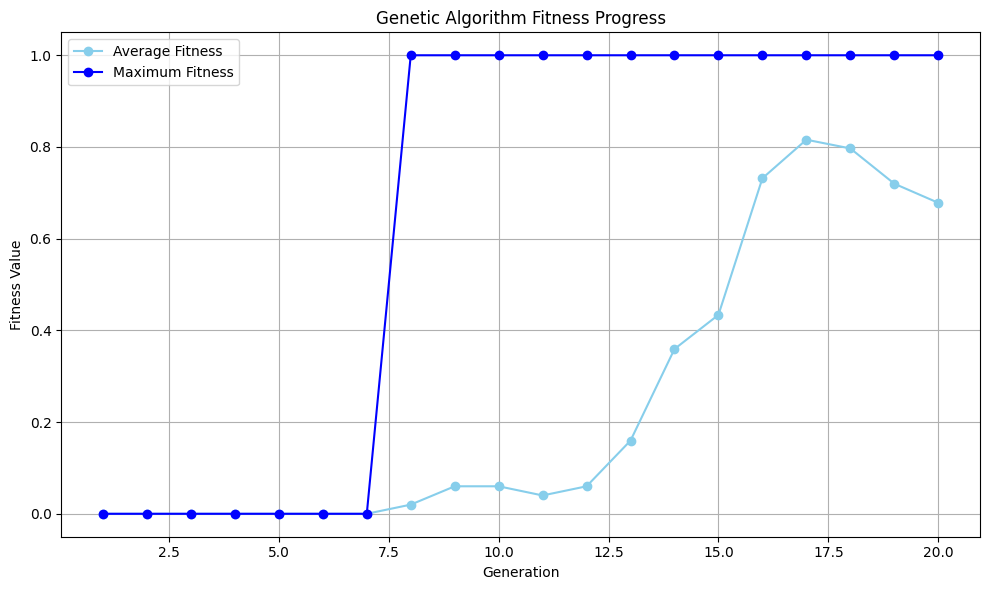

In [47]:
import warnings
import logging
import numpy as np
from deap import base, creator, tools, algorithms
import lightgbm as lgb
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt  # Import for graphing

# Suppress warnings and LightGBM logs
warnings.filterwarnings("ignore", category=FutureWarning)
logging.getLogger('lightgbm').setLevel(logging.ERROR)

# ---------------------------------------------------------------------------
# Ensure Alignment Between Features and Labels
# ---------------------------------------------------------------------------
if X_train_scaled.shape[0] != len(y_train):
    print("Mismatch detected between features and labels. Aligning shapes...")
    min_samples = min(X_train_scaled.shape[0], len(y_train))
    X_train_scaled = X_train_scaled[:min_samples]
    y_train = y_train[:min_samples]

# ---------------------------------------------------------------------------
# GA Setup Using DEAP
# ---------------------------------------------------------------------------
# Clear existing creator definitions if running multiple times
for name in ["FitnessMax", "Individual"]:
    if hasattr(creator, name):
        delattr(creator, name)

# Define fitness and individual
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Define toolbox components
toolbox = base.Toolbox()
num_features = X_train_scaled.shape[1]

toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=num_features)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# GA Hyperparameters
population_size = 50
n_generations = 20
crossover_prob = 0.9
mutation_prob = 0.4
mutation_indpb = 0.1
min_features = max(10, int(0.2 * num_features))  # At least 10 or 20% of total features

fitness_cache = {}  # Cache to avoid re-evaluating identical individuals

# ---------------------------------------------------------------------------
# Fitness Evaluation Function
# ---------------------------------------------------------------------------
def evaluate_individual(individual, min_features, eval_fraction=0.7):
    """
    Evaluate an individual's fitness by training LightGBM on the selected feature subset.
    Returns the accuracy as the fitness value.
    """
    key = tuple(individual)
    if key in fitness_cache:
        return fitness_cache[key]

    # Extract selected features
    selected = [i for i, bit in enumerate(individual) if bit]
    
    # Check minimum feature constraint
    if len(selected) < min_features:
        fitness_cache[key] = (0.0,)
        return (0.0,)

    # Subsample data
    num_samples = len(y_train)
    n_samples = int(num_samples * eval_fraction)
    indices = np.random.choice(num_samples, size=n_samples, replace=False)
    X_sub = X_train_scaled[indices][:, selected]
    y_sub = np.array(y_train)[indices]

    # Train LightGBM and calculate accuracy
    try:
        model = lgb.LGBMClassifier(**lgb_params)
        model.fit(X_sub, y_sub)
        y_pred = model.predict(X_sub)
        acc = accuracy_score(y_sub, y_pred)
        fitness_cache[key] = (acc,)
        return (acc,)
    except Exception as e:
        fitness_cache[key] = (0.0,)
        return (0.0,)

# Register genetic operators
toolbox.register("evaluate", evaluate_individual, min_features=min_features)
toolbox.register("mate", tools.cxUniform, indpb=0.5)
toolbox.register("mutate", tools.mutFlipBit, indpb=mutation_indpb)
toolbox.register("select", tools.selTournament, tournsize=3)

# ---------------------------------------------------------------------------
# Run GA Evolution
# ---------------------------------------------------------------------------
population = toolbox.population(n=population_size)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("max", np.max)

logbook = tools.Logbook()
logbook.header = ["gen", "avg", "max"]

fitness_values = {"avg": [], "max": []}

for gen in range(n_generations):
    print(f"Generation {gen + 1} in progress...")
    population, logbook = algorithms.eaSimple(
        population, toolbox,
        cxpb=crossover_prob, mutpb=mutation_prob, ngen=1,
        stats=stats, verbose=False
    )
    # Log progress for the current generation
    record = logbook[-1]
    fitness_values["avg"].append(record["avg"])
    fitness_values["max"].append(record["max"])
    print(f"Generation {gen + 1}: Avg Fitness = {record['avg']:.4f}, Max Fitness = {record['max']:.4f}")

# ---------------------------------------------------------------------------
# Extract Best Individual and Summary Results
# ---------------------------------------------------------------------------
best_individual = tools.selBest(population, k=1)[0]
selected_feature_indices = [i for i, bit in enumerate(best_individual) if bit]
selected_feature_names = [feature_names[i] for i in selected_feature_indices]

# Print summary
print("\n--- Genetic Algorithm Summary ---")
print(f"Total Generations: {n_generations}")
print(f"Final Average Fitness: {logbook[-1]['avg']:.4f}")
print(f"Final Maximum Fitness: {logbook[-1]['max']:.4f}")
print(f"Number of Selected Features: {len(selected_feature_names)}")
print("Selected Features:")
for feature in selected_feature_names:
    print(f"  - {feature}")

# ---------------------------------------------------------------------------
# Plot Fitness Values Across Generations
# ---------------------------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_generations + 1), fitness_values["avg"], label="Average Fitness", marker="o", color="skyblue")
plt.plot(range(1, n_generations + 1), fitness_values["max"], label="Maximum Fitness", marker="o", color="blue")
plt.title("Genetic Algorithm Fitness Progress")
plt.xlabel("Generation")
plt.ylabel("Fitness Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [48]:
print("Training LightGBM with 5-Fold Stratified Cross-Validation and Class Imbalance Handling")

# ---------------------------------------------------------------------------
# Prepare Data with Selected Features
# ---------------------------------------------------------------------------
X_selected = X_train_scaled[:, selected_feature_indices]
X_test_selected = X_test_scaled[:, selected_feature_indices]

# ---------------------------------------------------------------------------
# Set Up 5-Fold Stratified Cross-Validation
# ---------------------------------------------------------------------------
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []

# ---------------------------------------------------------------------------
# Perform 5-Fold Cross-Validation
# ---------------------------------------------------------------------------
for fold, (train_idx, val_idx) in enumerate(kf.split(X_selected, y_train), 1):
    print(f"\nTraining Fold {fold} of 5...")

    # Create training and validation datasets for the current fold
    X_train_fold = X_selected[train_idx]
    X_val_fold = X_selected[val_idx]
    y_train_fold = y_train.iloc[train_idx] if hasattr(y_train, "iloc") else y_train[train_idx]
    y_val_fold = y_train.iloc[val_idx] if hasattr(y_train, "iloc") else y_train[val_idx]

    # LightGBM classifier with class weights
    model = lgb.LGBMClassifier(
        **lgb_params,
        class_weight="balanced"  # Automatically balance class weights
    )
    model.fit(
        X_train_fold, y_train_fold,
        eval_set=[(X_val_fold, y_val_fold)],
        eval_metric="binary_logloss",  # Replace AUC with binary logloss
        callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=False)]  # Early stopping
    )

    # Make predictions on the validation set
    y_pred = model.predict(X_val_fold)

    # Calculate metrics
    fold_accuracy = accuracy_score(y_val_fold, y_pred)
    fold_precision = precision_score(y_val_fold, y_pred, average="weighted")
    fold_recall = recall_score(y_val_fold, y_pred, average="weighted")
    fold_f1 = f1_score(y_val_fold, y_pred, average="weighted")
    cm = confusion_matrix(y_val_fold, y_pred)

    # Store fold results
    fold_results.append({
        "Fold": fold,
        "Accuracy": fold_accuracy,
        "Precision": fold_precision,
        "Recall": fold_recall,
        "F1 Score": fold_f1,
        "Confusion Matrix": cm
    })

    # Print fold-specific metrics
    print(f"Fold {fold} Results:")
    print("  Accuracy: ", fold_accuracy)
    print("  Precision:", fold_precision)
    print("  Recall:   ", fold_recall)
    print("  F1 Score: ", fold_f1)
    print("  Confusion Matrix:")
    print(cm)

# ---------------------------------------------------------------------------
# Compute and Print Average Metrics Across All Folds
# ---------------------------------------------------------------------------
# Aggregate metrics across all folds
avg_accuracy = np.mean([result["Accuracy"] for result in fold_results])
avg_precision = np.mean([result["Precision"] for result in fold_results])
avg_recall = np.mean([result["Recall"] for result in fold_results])
avg_f1 = np.mean([result["F1 Score"] for result in fold_results])
avg_cm = np.mean(np.array([result["Confusion Matrix"] for result in fold_results]), axis=0)

# Format confusion matrix to avoid scientific notation
formatted_cm = np.array(avg_cm, dtype=int)  # Convert to integer for readability

# Print average metrics across folds
print("\nAverage Metrics Across All Folds:")
print("  Accuracy:", avg_accuracy)
print("  Precision:", avg_precision)
print("  Recall:", avg_recall)
print("  F1 Score:", avg_f1)
print("  Average Confusion Matrix:")
for row in formatted_cm:
    print("[", " ".join(map(str, row)), "]")

Training LightGBM with 5-Fold Stratified Cross-Validation and Class Imbalance Handling

Training Fold 1 of 5...
Fold 1 Results:
  Accuracy:  1.0
  Precision: 1.0
  Recall:    1.0
  F1 Score:  1.0
  Confusion Matrix:
[[    74      0]
 [     0 586890]]

Training Fold 2 of 5...
Fold 2 Results:
  Accuracy:  0.9999982963180025
  Precision: 0.9999982963209053
  Recall:    0.9999982963180025
  F1 Score:  0.9999982905238913
  Confusion Matrix:
[[    73      1]
 [     0 586890]]

Training Fold 3 of 5...
Fold 3 Results:
  Accuracy:  0.9999948889452998
  Precision: 0.9999949343739942
  Recall:    0.9999948889452998
  F1 Score:  0.999994906094313
  Confusion Matrix:
[[    73      1]
 [     2 586887]]

Training Fold 4 of 5...
Fold 4 Results:
  Accuracy:  1.0
  Precision: 1.0
  Recall:    1.0
  F1 Score:  1.0
  Confusion Matrix:
[[    74      0]
 [     0 586889]]

Training Fold 5 of 5...
Fold 5 Results:
  Accuracy:  1.0
  Precision: 1.0
  Recall:    1.0
  F1 Score:  1.0
  Confusion Matrix:
[[    74 

In [49]:
# ---------------------------------------------------------------------------
# Train and Save the Final LightGBM Model
# ---------------------------------------------------------------------------
# This cell trains the final LightGBM model using all the training data,
# but only with the features that were selected by the GA.
#
# Variables assumed to be available in the environment:
#   - X_selected: A NumPy array containing training features corresponding to the selected feature indices.
#   - y_train: Training labels (can be a pandas Series or NumPy array).
#   - lgb_params: Dictionary of LightGBM hyperparameters defined earlier in the pipeline.
#
# After training, the model is saved to disk using Joblib.

# Initialize the LightGBM classifier with the predefined parameters.
final_model = lgb.LGBMClassifier(**lgb_params)

# Train the final model on the entire training set using only the selected features.
final_model.fit(X_selected, y_train)

# Save the final trained model to a file for later use (e.g., during deployment or further evaluation).
joblib.dump(final_model, "final_lightgbm_model.joblib")
print("Final LightGBM model saved as 'final_lightgbm_model.joblib'.")

Final LightGBM model saved as 'final_lightgbm_model.joblib'.


In [50]:
print("Testing for Overfitting: Comparing Training and Test Performance")

# ---------------------------------------------------------------------------
# Evaluate Performance on the Training Set
# ---------------------------------------------------------------------------
# Get predictions on the training set using the final model.
y_pred_train = final_model.predict(X_selected)

# Calculate performance metrics on the training set (using full precision).
train_accuracy  = accuracy_score(y_train, y_pred_train)
train_precision = precision_score(y_train, y_pred_train, average='weighted')
train_recall    = recall_score(y_train, y_pred_train, average='weighted')
train_f1        = f1_score(y_train, y_pred_train, average='weighted')
train_cm        = confusion_matrix(y_train, y_pred_train)

print("\nTraining Metrics (Full Precision):")
print("  Accuracy:", train_accuracy)
print("  Precision:", train_precision)
print("  Recall:", train_recall)
print("  F1 Score:", train_f1)
print("  Confusion Matrix:")
print(train_cm)

# ---------------------------------------------------------------------------
# Evaluate Performance on the Test Set
# ---------------------------------------------------------------------------
# Get predictions on the test set.
y_pred_test = final_model.predict(X_test_selected)

# Calculate performance metrics on the test set (using full precision).
test_accuracy  = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test, average='weighted')
test_recall    = recall_score(y_test, y_pred_test, average='weighted')
test_f1        = f1_score(y_test, y_pred_test, average='weighted')
test_cm        = confusion_matrix(y_test, y_pred_test)

print("\nTest Metrics (Full Precision):")
print("  Accuracy:", test_accuracy)
print("  Precision:", test_precision)
print("  Recall:", test_recall)
print("  F1 Score:", test_f1)
print("  Confusion Matrix:")
print(test_cm)

# ---------------------------------------------------------------------------
# Overfitting Check
# ---------------------------------------------------------------------------
# A significant drop in performance from training to test can indicate overfitting.
print("\nOverfitting Assessment:")

# Here we simply compare training and test metrics.
# You may adjust the threshold (e.g. 1% drop) based on domain requirements.
accuracy_drop = train_accuracy - test_accuracy

print("  Difference in Accuracy (Training - Test):", accuracy_drop)
print("  Training Accuracy:", train_accuracy)
print("  Test Accuracy:", test_accuracy)

if accuracy_drop > 0.05:
    print("Warning: The model may be overfitting because there is a significant drop in accuracy from training to test.")
else:
    print("The model generalizes well. Training and test metrics are comparable, indicating minimal overfitting.")

Testing for Overfitting: Comparing Training and Test Performance

Training Metrics (Full Precision):
  Accuracy: 0.9997182107095605
  Precision: 0.9997478510687295
  Recall: 0.9997182107095605
  F1 Score: 0.9997330306694486
  Confusion Matrix:
[[      0     370]
 [    457 2933990]]

Test Metrics (Full Precision):
  Accuracy: 0.9996960631316401
  Precision: 0.9997083278528507
  Recall: 0.9996960631316401
  F1 Score: 0.9997021954546284
  Confusion Matrix:
[[     0    107]
 [   116 733482]]

Overfitting Assessment:
  Difference in Accuracy (Training - Test): 2.2147577920406114e-05
  Training Accuracy: 0.9997182107095605
  Test Accuracy: 0.9996960631316401
The model generalizes well. Training and test metrics are comparable, indicating minimal overfitting.
